In [1]:
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import albumentations as A
from torch.utils.data import DataLoader
import os
import torch
import torch.utils.data
from PIL import Image
import numpy as np
import cv2
from torchvision.transforms import ToTensor
from IPython.display import clear_output

from tqdm.notebook import tqdm
import time

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
train_df = pkl.load(open('train_v4_df.pkl','rb+'))
test_df = pkl.load(open('test_v4_df.pkl','rb+'))

pos_box2id = {k:v for k,v in pkl.load(open('pos_box2id.pkl', 'rb+')).items() if v!=-1}
neg_box2id = {k:v for k,v in pkl.load(open('neg_box2id.pkl', 'rb+')).items() if len(v)>0}

df = pd.concat([train_df, test_df], axis=0)
print(len(pos_box2id), len(neg_box2id))
df.head(3)

919 2922


name                                               path  \
0  100849_10b  /home/ubuntu/storage/Doc2Answer/download_from_...   
1  100849_10b  /home/ubuntu/storage/Doc2Answer/download_from_...   
2  100849_10b  /home/ubuntu/storage/Doc2Answer/download_from_...   

                   points  box_id  
0  (285, 1010, 481, 1213)       1  
1   (881, 300, 1074, 483)       2  
2   (103, 998, 299, 1201)       1

In [3]:
DATA_DIR = 'stamp_groups'
groups = os.listdir(DATA_DIR)
group2paths = {k:[os.path.join(DATA_DIR, k, fn) for fn in os.listdir(os.path.join(DATA_DIR, k)) if not os.path.isdir(os.path.join(DATA_DIR, k, fn))] for k in groups}

train_group2paths = {k:v[:4*len(v)//5] if len(v)>5 else v for k,v in group2paths.items()}
test_group2paths = {k:v[4*len(v)//5:] if len(v)>5 else v[-1:] for k,v in group2paths.items()}

In [4]:
len(train_group2paths), len(test_group2paths)

(97, 97)

In [5]:
classes = set(pos_box2id.values()) | set([el for negs in neg_box2id.values() for el in negs])
classes.discard(-1)

In [6]:
catalogue_sets = {k: set() for k in classes}

In [7]:
for k,v in pos_box2id.items():
    catalogue_sets[v].add(k)

In [8]:
len([v for k,v in catalogue_sets.items() if len(v)>0]), len([v for k,v in catalogue_sets.items() if len(v)>1])

(59, 45)

In [9]:
train_names = train_df.name.unique()
test_names = test_df.name.unique()

In [10]:
DETECTION_FOLDER = '/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/'
card2paths = {card: [os.path.join(DETECTION_FOLDER, card, fn)
                     for fn in os.listdir(os.path.join(DETECTION_FOLDER, card)) if fn.endswith('.jpg')]   
         for card in os.listdir(DETECTION_FOLDER)}

train_card2paths = {card: [os.path.join(DETECTION_FOLDER, card, fn)
                           for fn in os.listdir(os.path.join(DETECTION_FOLDER, card))  if fn.endswith('.jpg')]
         for card in os.listdir(DETECTION_FOLDER) if card in train_names}

test_card2paths = {card: [os.path.join(DETECTION_FOLDER, card, fn)
                          for fn in os.listdir(os.path.join(DETECTION_FOLDER, card))  if fn.endswith('.jpg')]
         for card in os.listdir(DETECTION_FOLDER) if card in test_names}

len(train_card2paths), len(test_card2paths), len(card2paths)

(665, 112, 777)

In [11]:
class SiameseStampsGroupDataset(torch.utils.data.Dataset):
    def __init__(self, group2paths, same_p, conf_mat, transforms=None):
        self.groups = list(group2paths.keys())
        self.same_p = same_p
        self.conf_mat = conf_mat
        self.group2paths = group2paths
        self.boxes = [box for group in self.groups for box in self.group2paths[group]]
        self.transforms = transforms
        if self.transforms is not None:
            self.same_transforms, self.diff_transforms = self.transforms
        self.n_groups = len(self.groups)
        self.n_boxes = sum([len(self.group2paths[group]) for group in self.groups])
        

    def __getitem__(self, idx):
        idx = idx % self.n_boxes
        box_path1 = self.boxes[idx]
        group1 = [split for split in box_path1.split('/') if 'group' in split][1]
        group1_idx = int(group1[-3:])
        try:
            patch1 = cv2.cvtColor(cv2.imread(box_path1), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
        except:
            print(box_path1)
                
        same = np.random.choice([0,1], p=[1. - self.same_p, self.same_p])
        if same:
            group2 = group1
            if len(self.group2paths[group1]) > 1:
                box_path2 = np.random.choice([box_path for box_path in self.group2paths[group1] if box_path != box_path1])
                try:
                    patch2 = cv2.cvtColor(cv2.imread(box_path2), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
                except:
                    print(box_path2)
            else:
                patch2 = patch1.copy()
        else:            
            group2 = None
            while group2 == group1 or group2 is None:
                group2 = np.random.choice(self.groups, p=self.conf_mat[group1_idx])
            negative_paths = [box_path for box_path in self.group2paths[group2]]
            box_path2 = np.random.choice(negative_paths)
            try:
                patch2 = cv2.cvtColor(cv2.imread(box_path2), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
            except:
                print(box_path2)
        
        target = torch.ones((1,), dtype=torch.float32) if same else torch.zeros((1,), dtype=torch.float32)
        if self.transforms is not None:
            patch1 = self.same_transforms(image=patch1)['image']
            if same:
                patch2 = self.same_transforms(image=patch2)['image']
            else:
                patch2 = self.diff_transforms(image=patch2)['image']
        
        patch1 = ToTensor()(patch1)
        patch2 = ToTensor()(patch2)
        return torch.cat([patch1, patch2], dim=0), target, (int(group1[-3:]), int(group2[-3:]))
    
    def __len__(self):
        return self.n_boxes*5

In [12]:
class SiameseStampsDataset(torch.utils.data.Dataset):
    def __init__(self, card2paths, catalogue_sets, pos_box2id, neg_box2id, transforms=None):
        self.cards = list(card2paths.keys())
        self.card2paths = card2paths
        self.transforms = transforms
        self.catalogue_sets, self. pos_box2id, self.neg_box2id = catalogue_sets, pos_box2id, neg_box2id
        if self.transforms is not None:
            self.same_transforms, self.diff_transforms = self.transforms
        self.n_paths = len(self.cards)
        self.n_boxes = [len(self.card2paths[card]) for card in self.cards]
        

    def __getitem__(self, idx):
        idx = idx % self.n_paths
        card1 = self.cards[idx]
        weights = np.array([10 if path in pos_box2id or path in neg_box2id else 1 for path in self.card2paths[card1]])
        weights = weights / np.sum(weights)
        box_path1 = np.random.choice(self.card2paths[card1], p=weights)
        try:
            patch1 = cv2.cvtColor(cv2.imread(box_path1), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
        except:
            print(box_path1)
                
        same = np.random.choice([0,1], p=[.5, .5])
        if same:
            if box_path1 in self.pos_box2id and np.random.random() > .5/(len(self.catalogue_sets[self.pos_box2id[box_path1]])-1+1e-6):
                box_path2 = np.random.choice(list(self.catalogue_sets[self.pos_box2id[box_path1]]))
                try:
                    patch2 = cv2.cvtColor(cv2.imread(box_path2), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
                except:
                    print(box_path2)
            else:
                patch2 = patch1.copy()
        else:            
            if box_path1 in self.neg_box2id:
                negative_paths = [el for catalogue_id in self.neg_box2id[box_path1] for el in self.catalogue_sets[catalogue_id]]
            if box_path1 in self.neg_box2id and len(negative_paths)>0 and np.random.random() > .75/(len(negative_paths)):
                box_path2 = np.random.choice(negative_paths)
            else:
                negative_paths = [card for card in self.cards if card != card1]
                negative_counts = np.array([self.n_boxes[i] for i in range(len(self.cards)) if self.cards[i] != card1])
                negative_ps = negative_counts / np.sum(negative_counts)
                card2 = np.random.choice(negative_paths, p= negative_ps)
                box_path2 = np.random.choice(self.card2paths[card2])
            try:
                patch2 = cv2.cvtColor(cv2.imread(box_path2), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
            except:
                print(box_path2)
        
        target = torch.ones((1,), dtype=torch.float32) if same else torch.zeros((1,), dtype=torch.float32)
        if self.transforms is not None:
            patch1 = self.same_transforms(image=patch1)['image']
            if same:
                patch2 = self.same_transforms(image=patch2)['image']
            else:
                patch2 = self.diff_transforms(image=patch2)['image']
        
        patch1 = ToTensor()(patch1)
        patch2 = ToTensor()(patch2)
        return torch.cat([patch1, patch2], dim=0), target
    
    
    def get_same_cards(self, card, show=False):
        box_paths = self.card2paths[card]
        patches = None
        img_patches = []
        for box_path in box_paths:
            patch = cv2.cvtColor(cv2.imread(box_path), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
            patch = self.same_transforms(image=patch)['image']
            if show:
                img_patches.append(patch.copy())
            patch = ToTensor()(patch)[None, :]
            if patches is None:
                patches = patch
            else:
                patches = torch.cat([patches, patch], dim=0)
        if show:
            return patches, img_patches
        return patches
    
    def get_boxes(self, box_paths, show=False):
        patches = None
        img_patches = []
        for box_path in box_paths:
            patch = cv2.cvtColor(cv2.imread(box_path), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
            patch = self.same_transforms(image=patch)['image']
            if show:
                img_patches.append(patch.copy())
            patch = ToTensor()(patch)[None, :]
            if patches is None:
                patches = patch
            else:
                patches = torch.cat([patches, patch], dim=0)
        if show:
            return patches, img_patches
        return patches
    
    def preprocesses(self, img, boxes, show=False):
        patches = None
        img_patches = []
        for box in boxes:
            patch = img[box[1]:box[3], box[0]:box[2]].copy().astype(np.float32) / 255.
            patch = self.same_transforms(image=patch)['image']
            if show:
                img_patches.append(patch.copy())
            patch = ToTensor()(patch)[None, :]
            if patches is None:
                patches = patch
            else:
                patches = torch.cat([patches, patch], dim=0)
        if show:
            return patches, img_patches
        return patches

    def __len__(self):
        return self.n_paths * 3

In [13]:
# catalogue_sets

In [14]:
from torchvision.models import SqueezeNet
import torch
from torch import nn

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50 


class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(3, 64, 9),  # 64@96*96
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # 64@48*48
#             nn.Conv2d(64, 128, 7),
#             nn.ReLU(),    # 128@42*42
#             nn.MaxPool2d(2),   # 128@21*21
#             nn.Conv2d(128, 128, 5),
#             nn.ReLU(), # 128@18*18
#             nn.MaxPool2d(2), # 128@9*9
#             nn.Conv2d(128, 128, 3),
#             nn.ReLU(),   # 256@6*6
# #             nn.MaxPool2d(2), # 128@9*9
#             nn.Conv2d(128, 128, 3),
#             nn.ReLU(),   # 256@6*6
#         )
        self.feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
        self.feature_extractor.classifier[1] = nn.Conv2d(512, 2048, kernel_size=(1,1), stride=(1,1))
#         self.feature_extractor.classifier.add_module('4', nn.Linear(2048, 2048))
#         self.feature_extractor.classifier.add_module('5', nn.Sigmoid())
        self.linear = nn.Sequential(nn.Linear(2048, 2048), nn.Sigmoid())

    def forward_one(self, x):
        x = self.feature_extractor(x)
#         x = x.view(x.size()[0], -1)
        x = (self.linear(x) * 2.) - 1
#         x = (2. * x) - 1.
        x = x / (torch.norm(x, dim=1, keepdim=True) + 1e-6)
        return x

    def forward(self, x_pair):
        x1, x2 = x_pair[:,:3], x_pair[:,3:]
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        sim = (torch.sum(torch.mul(out1, out2), dim=1) + 1) / 2.
        #  return self.sigmoid(out)
        return sim


In [16]:
net = Siamese()
net.to(DEVICE)
print('Moaded loaded!')

Moaded loaded!


Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.10.0


In [17]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin


    def forward(self, sim, y):

        # euclidian distance
        dist = (2. * (1. - sim))

        mdist = self.margin - dist
        ndist = torch.clamp(mdist, min=0.0)
        loss = y * torch.pow(dist, 2) + (1. - y) * torch.pow(ndist, 2)
        loss = torch.sum(loss) / 2.0 / sim.size()[0]
        return loss

In [18]:
loss_fn = ContrastiveLoss()
lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [19]:
import string

In [20]:
def add_text(img, cols=None, rows=None):
    img = (img*255).astype(np.uint8)
    height, width = 128, 128
    N = np.random.randint(1,20)
    text = ''.join(np.random.choice([char for char in string.ascii_uppercase + string.digits+' ']) for _ in range(N))
    x, y = np.random.randint(-width//10, width-10), np.random.randint(-height//10, height-10)
    fonts = [cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_COMPLEX_SMALL, cv2.FONT_HERSHEY_DUPLEX,
            cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_SCRIPT_COMPLEX, cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, cv2.FONT_HERSHEY_SIMPLEX,
            cv2.FONT_HERSHEY_TRIPLEX, cv2.FONT_ITALIC]
    color = (np.random.randint(0, 200), np.random.randint(0, 200), np.random.randint(0, 200))
    cv2.putText(img, text, (x, y), np.random.choice(fonts), np.random.randint(1, 8)/2, color, np.random.randint(1, 4))
    return img.astype(np.float32) / 255

def add_random_circle(img, cols=None, rows=None):
    img = (img*255).astype(np.uint8)
    height, width = 128, 128
    x, y = np.random.randint(-width//10, width-10), np.random.randint(-height//10, height-10)
    #55, 54, 69, 3.4. 3.9, 4.9
    color = (int(np.random.normal(55, 3.4)), int(np.random.normal(54, 3.9)), int(np.random.normal(69, 4.9)))
    radius = np.random.randint(4, 20)
    cv2.circle(img, (x, y), radius, color, -1)
    return img.astype(np.float32) / 255.

In [21]:
same_transforms = A.Compose([
    A.RandomResizedCrop(128, 128, scale=(0.7,1.)),
    A.Rotate(limit=(80,100), p=.1),
    A.Rotate(limit=(80,100), p=.1),
    A.Lambda(add_text, p=.2),
    A.Lambda(add_random_circle, p=.1),
    A.CoarseDropout(p=.1),
    A.Perspective(p=.2),
    A.Blur(blur_limit=3, p=.2),
    A.ColorJitter(p=.5, brightness=0.1, contrast=0.1, saturation=0., hue=0.)])

diff_transforms = A.Compose([
    A.RandomResizedCrop(128, 128, scale=(0.7,1.)),
    A.Rotate(limit=(80,100), p=.1),
    A.Rotate(limit=(80,100), p=.1),
    A.Lambda(add_text, p=.1),
    A.Lambda(add_random_circle, p=.1),
    A.CoarseDropout(p=.1),
    A.Perspective(p=.1),
    A.Blur(blur_limit=3, p=.1),
    A.ColorJitter(p=.5, brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0)])

dummy_transforms = A.Compose([
    A.Resize(128, 128)])

In [22]:
# train_card2paths

In [23]:
# imgs_x, labels = trainSet[0]
# img1 = np.concatenate([channel[:,:, None] for channel in imgs_x[:3]], axis=2)
# img2 = np.concatenate([channel[:,:, None] for channel in imgs_x[3:]], axis=2)
# print(labels)
# plt.imshow(img1); plt.show()
# plt.imshow(img2); plt.show()

In [24]:
# shutil.rmtree('./stamp_groups/')

In [25]:
# os.makedirs('./stamp_groups', exist_ok=True)
# for k, v in catalogue_sets.items():
#     group_folder = 'stamp_groups/group_{}'.format(str(k).zfill(3))
#     os.makedirs(group_folder,exist_ok=True)
#     v = set(v)
#     for path in v:
#         dst_path = os.path.join(group_folder, path.split('/')[-1])
#         if not os.path.isfile(dst_path):
#             shutil.copy(path, dst_path)
            
# template_paths = sorted([os.path.join('catalogue', fn) for fn in os.listdir('catalogue') if fn.endswith('.jpg')])

            
# for k, path in enumerate(template_paths):
#     group_folder = 'stamp_groups/group_{}'.format(str(k).zfill(3))
#     os.makedirs(group_folder,exist_ok=True)
#     dst_path = os.path.join(group_folder, '{}_template.jpg'.format(str(k).zfill(3)))
#     if not os.path.isfile(dst_path):
#         shutil.copy(path, dst_path)

In [45]:
EPOCHS = 50
# ALPHA = 0.8
# epochs_history = []
# conf_mat = np.ones((len(groups), len(groups))) * np.array([len(v) for k,v in train_group2paths.items()])
# conf_mat = conf_mat / conf_mat.sum(axis=1)
# best_avg_err = 1.
# no_improvement = 0

for epoch in range(EPOCHS):
    
    trainSet = SiameseStampsGroupDataset(train_group2paths, same_p=.3, conf_mat=conf_mat, transforms=[same_transforms, diff_transforms]) 
    testSet = SiameseStampsGroupDataset(test_group2paths, same_p=.3, conf_mat=conf_mat, transforms=[same_transforms, diff_transforms]) 

    trainLoader = DataLoader(trainSet, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
    testLoader = DataLoader(testSet, batch_size=100, shuffle=False, pin_memory=True, num_workers=4)
    
    net.train()
    loss_val, train_acc = 0, 0
    for batch_id, (X_pairs, targets, _) in enumerate(tqdm(trainLoader)):
        optimizer.zero_grad()
        X_pairs = X_pairs.to(DEVICE)
        sims = net(X_pairs)
        targets = targets[:, 0].to(DEVICE)
        train_acc += torch.mean(((sims>.5) == targets).float()).item()
        loss = loss_fn(sims, targets)
        loss_val += loss.item()
        loss.backward()
        optimizer.step()
        del X_pairs; del sims; del targets
        
    test_loss_val, test_acc = 0, 0
    optimizer.zero_grad()
    net.eval()
    for test_batch_id, (X_pairs, targets, _) in enumerate(tqdm(testLoader)):
        with torch.no_grad():
            X_pairs = X_pairs.to(DEVICE)
            sims = net(X_pairs)
            targets = targets[:, 0].to(DEVICE)
            test_acc += torch.mean(((sims>.5) == targets).float()).item()
            loss = loss_fn(sims, targets)
            test_loss_val += loss.item()
        del X_pairs; del sims; del targets
        
    # compute confusion matrix
    inferenceSet = SiameseStampsDataset(card2paths, {}, {}, {}, [dummy_transforms, dummy_transforms])         
    template_paths = sorted([sorted(paths) for group, paths in train_group2paths.items()])
    template_vecs = np.zeros((len(template_paths), 2048))
    
    for i, group_paths in enumerate(template_paths):
        template_patches_i = inferenceSet.get_boxes(group_paths, False)

        template_patches_GPU_i = template_patches_i.to(DEVICE)
        net.eval()
        with torch.no_grad():
            template_vecs_i = net.forward_one(template_patches_GPU_i).cpu().detach().numpy()
        del template_patches_GPU_i
        template_vecs[i] = template_vecs_i.mean(axis=0)

    new_conf_mat = np.zeros((len(groups),len(groups)))
    err_mat = np.zeros((len(groups),len(groups)))

    test_paths = sorted([sorted(paths) for group, paths in test_group2paths.items()])

    for i, group_paths in enumerate(test_paths):
        test_patches_i = inferenceSet.get_boxes(group_paths, False)
        test_patches_GPU_i = test_patches_i.to(DEVICE)
        net.eval()
        with torch.no_grad():
            test_vecs_i = net.forward_one(test_patches_GPU_i).cpu().detach().numpy()
            scores = np.sum(np.mean(test_vecs_i, axis=0)* template_vecs, axis=1).ravel()
            scores = np.clip(scores, scores[scores>0].min(), 1.)
            scores[i] = 1. - scores[i]
            err_mat[i] = scores
            scores = scores**5
            new_conf_mat[i] = scores / np.sum(scores)
        del test_patches_GPU_i
            
    conf_mat = (1.-ALPHA) * conf_mat + ALPHA * new_conf_mat
    conf_mat = conf_mat / conf_mat.sum(axis=1)
    
    epochs_history.append([loss_val/batch_id, test_loss_val/test_batch_id, train_acc/batch_id, test_acc/test_batch_id])
    avg_err = np.mean(err_mat)
    if avg_err < best_avg_err and epoch > 0:
        torch.save(net.state_dict(), 'SiameseStampNet-checkpoint-v6.pt')
        best_avg_err = avg_err
        print('New checkpoint saved!')
        no_improvement = 0
    else:
        no_improvement += 1
    if no_improvement == 15:
        if lr > 5e-6:
            lr *= 0.1
            optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    print('Epoch#{} ==> Train Loss: {:.3f} Train Acc: {:.3f} | Test Loss: {:.3f} Test Acc: {:.3f} Err Mat: {:.3f}'.format(
        epoch, loss_val/batch_id, train_acc/batch_id, test_loss_val/test_batch_id, test_acc/test_batch_id, avg_err))


Epoch#0 ==> Train Loss: 0.004 Train Acc: 0.404 | Test Loss: 0.009 Test Acc: 0.399 Err Mat: 0.005



Epoch#1 ==> Train Loss: 0.004 Train Acc: 0.442 | Test Loss: 0.010 Test Acc: 0.447 Err Mat: 0.005



Epoch#2 ==> Train Loss: 0.004 Train Acc: 0.431 | Test Loss: 0.009 Test Acc: 0.442 Err Mat: 0.005



Epoch#3 ==> Train Loss: 0.004 Train Acc: 0.429 | Test Loss: 0.009 Test Acc: 0.427 Err Mat: 0.005



New checkpoint saved!
Epoch#4 ==> Train Loss: 0.004 Train Acc: 0.415 | Test Loss: 0.009 Test Acc: 0.423 Err Mat: 0.005



New checkpoint saved!
Epoch#5 ==> Train Loss: 0.004 Train Acc: 0.428 | Test Loss: 0.010 Test Acc: 0.438 Err Mat: 0.005



New checkpoint saved!
Epoch#6 ==> Train Loss: 0.004 Train Acc: 0.413 | Test Loss: 0.009 Test Acc: 0.428 Err Mat: 0.005



Epoch#7 ==> Train Loss: 0.004 Train Acc: 0.422 | Test Loss: 0.010 Test Acc: 0.424 Err Mat: 0.005



Epoch#8 ==> Train Loss: 0.004 Train Acc: 0.422 | Test Loss: 0.010 Test Acc: 0.437 Err Mat: 0.005



Epoch#9 ==> Train Loss: 0.004 Train Acc: 0.428 | Test Loss: 0.009 Test Acc: 0.441 Err Mat: 0.005



New checkpoint saved!
Epoch#10 ==> Train Loss: 0.004 Train Acc: 0.424 | Test Loss: 0.008 Test Acc: 0.424 Err Mat: 0.005



Epoch#11 ==> Train Loss: 0.004 Train Acc: 0.421 | Test Loss: 0.009 Test Acc: 0.426 Err Mat: 0.005



New checkpoint saved!
Epoch#12 ==> Train Loss: 0.004 Train Acc: 0.420 | Test Loss: 0.009 Test Acc: 0.423 Err Mat: 0.005



New checkpoint saved!
Epoch#13 ==> Train Loss: 0.004 Train Acc: 0.430 | Test Loss: 0.009 Test Acc: 0.441 Err Mat: 0.005



Epoch#14 ==> Train Loss: 0.004 Train Acc: 0.422 | Test Loss: 0.009 Test Acc: 0.429 Err Mat: 0.005



Epoch#15 ==> Train Loss: 0.004 Train Acc: 0.438 | Test Loss: 0.009 Test Acc: 0.438 Err Mat: 0.005



Epoch#16 ==> Train Loss: 0.004 Train Acc: 0.421 | Test Loss: 0.010 Test Acc: 0.418 Err Mat: 0.005



New checkpoint saved!
Epoch#17 ==> Train Loss: 0.004 Train Acc: 0.425 | Test Loss: 0.009 Test Acc: 0.425 Err Mat: 0.005



Epoch#18 ==> Train Loss: 0.004 Train Acc: 0.432 | Test Loss: 0.009 Test Acc: 0.443 Err Mat: 0.005



New checkpoint saved!
Epoch#19 ==> Train Loss: 0.004 Train Acc: 0.421 | Test Loss: 0.009 Test Acc: 0.417 Err Mat: 0.005



Epoch#20 ==> Train Loss: 0.004 Train Acc: 0.451 | Test Loss: 0.009 Test Acc: 0.445 Err Mat: 0.005



Epoch#21 ==> Train Loss: 0.004 Train Acc: 0.443 | Test Loss: 0.009 Test Acc: 0.443 Err Mat: 0.005



Epoch#22 ==> Train Loss: 0.004 Train Acc: 0.432 | Test Loss: 0.010 Test Acc: 0.431 Err Mat: 0.005



Epoch#23 ==> Train Loss: 0.004 Train Acc: 0.421 | Test Loss: 0.010 Test Acc: 0.424 Err Mat: 0.005



Epoch#24 ==> Train Loss: 0.004 Train Acc: 0.424 | Test Loss: 0.010 Test Acc: 0.432 Err Mat: 0.005



Epoch#25 ==> Train Loss: 0.004 Train Acc: 0.444 | Test Loss: 0.009 Test Acc: 0.446 Err Mat: 0.005



Epoch#26 ==> Train Loss: 0.004 Train Acc: 0.437 | Test Loss: 0.010 Test Acc: 0.447 Err Mat: 0.005



New checkpoint saved!
Epoch#27 ==> Train Loss: 0.004 Train Acc: 0.433 | Test Loss: 0.009 Test Acc: 0.450 Err Mat: 0.004



New checkpoint saved!
Epoch#28 ==> Train Loss: 0.004 Train Acc: 0.432 | Test Loss: 0.009 Test Acc: 0.428 Err Mat: 0.004



Epoch#29 ==> Train Loss: 0.004 Train Acc: 0.463 | Test Loss: 0.010 Test Acc: 0.459 Err Mat: 0.005



New checkpoint saved!
Epoch#30 ==> Train Loss: 0.004 Train Acc: 0.454 | Test Loss: 0.010 Test Acc: 0.460 Err Mat: 0.004



Epoch#31 ==> Train Loss: 0.004 Train Acc: 0.431 | Test Loss: 0.009 Test Acc: 0.443 Err Mat: 0.005



Epoch#32 ==> Train Loss: 0.004 Train Acc: 0.417 | Test Loss: 0.010 Test Acc: 0.431 Err Mat: 0.005



New checkpoint saved!
Epoch#33 ==> Train Loss: 0.004 Train Acc: 0.420 | Test Loss: 0.009 Test Acc: 0.413 Err Mat: 0.004



Epoch#34 ==> Train Loss: 0.004 Train Acc: 0.432 | Test Loss: 0.009 Test Acc: 0.427 Err Mat: 0.004



Epoch#35 ==> Train Loss: 0.004 Train Acc: 0.421 | Test Loss: 0.009 Test Acc: 0.419 Err Mat: 0.004



New checkpoint saved!
Epoch#36 ==> Train Loss: 0.004 Train Acc: 0.438 | Test Loss: 0.009 Test Acc: 0.451 Err Mat: 0.004



Epoch#37 ==> Train Loss: 0.004 Train Acc: 0.416 | Test Loss: 0.009 Test Acc: 0.410 Err Mat: 0.004



Epoch#38 ==> Train Loss: 0.004 Train Acc: 0.424 | Test Loss: 0.010 Test Acc: 0.433 Err Mat: 0.004



New checkpoint saved!
Epoch#39 ==> Train Loss: 0.004 Train Acc: 0.425 | Test Loss: 0.010 Test Acc: 0.438 Err Mat: 0.004



New checkpoint saved!
Epoch#40 ==> Train Loss: 0.004 Train Acc: 0.425 | Test Loss: 0.009 Test Acc: 0.429 Err Mat: 0.004



Epoch#41 ==> Train Loss: 0.004 Train Acc: 0.432 | Test Loss: 0.011 Test Acc: 0.432 Err Mat: 0.004



Epoch#42 ==> Train Loss: 0.004 Train Acc: 0.431 | Test Loss: 0.009 Test Acc: 0.427 Err Mat: 0.004



Epoch#43 ==> Train Loss: 0.004 Train Acc: 0.418 | Test Loss: 0.010 Test Acc: 0.419 Err Mat: 0.004



Epoch#44 ==> Train Loss: 0.004 Train Acc: 0.447 | Test Loss: 0.009 Test Acc: 0.460 Err Mat: 0.004



Epoch#45 ==> Train Loss: 0.004 Train Acc: 0.458 | Test Loss: 0.008 Test Acc: 0.461 Err Mat: 0.004



Epoch#46 ==> Train Loss: 0.004 Train Acc: 0.434 | Test Loss: 0.010 Test Acc: 0.450 Err Mat: 0.005



Epoch#47 ==> Train Loss: 0.004 Train Acc: 0.443 | Test Loss: 0.009 Test Acc: 0.452 Err Mat: 0.004



Epoch#48 ==> Train Loss: 0.004 Train Acc: 0.445 | Test Loss: 0.011 Test Acc: 0.440 Err Mat: 0.004



New checkpoint saved!
Epoch#49 ==> Train Loss: 0.004 Train Acc: 0.454 | Test Loss: 0.010 Test Acc: 0.435 Err Mat: 0.004


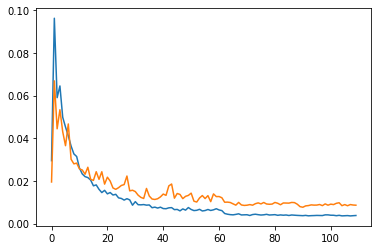

In [40]:
plt.plot(np.array(epochs_history)[:,0])
plt.plot(np.array(epochs_history)[:,1])

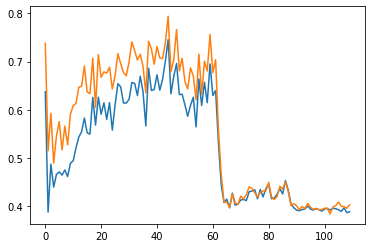

In [44]:
plt.plot(np.array(epochs_history)[:,2])
plt.plot(np.array(epochs_history)[:,3]*batch_id/test_batch_id)

In [24]:
inferenceSet = SiameseStampsDataset(card2paths, {}, {}, {}, [dummy_transforms, dummy_transforms])         
template_paths = sorted([sorted(paths) for group, paths in train_group2paths.items()])
template_vecs = np.zeros((len(template_paths), 2048))

for i, group_paths in enumerate(template_paths):
    template_patches_i = inferenceSet.get_boxes(group_paths, False)

    template_patches_GPU_i = template_patches_i.to(DEVICE)
    net.eval()
    with torch.no_grad():
        template_vecs_i = net.forward_one(template_patches_GPU_i).cpu().detach().numpy()
    del template_patches_GPU_i
    template_vecs[i] = template_vecs_i.mean(axis=0)

In [50]:
inferenceSet.n_boxes

2014

In [53]:
template_vecs = pkl.load(open('../best_models_to_date/stamp_classification/template_vecs.pkl', 'rb+'))

In [54]:
inferenceSet = SiameseStampsGroupDataset(test_group2paths, same_p=1, conf_mat=None, transforms=[dummy_transforms, dummy_transforms]) 
cont = 0
same = 0
for imgs, _, (group1, groups2) in tqdm(inferenceSet):
    if cont == inferenceSet.n_boxes:
        break
    X_img = imgs[:3][None, :]
    vec = net.forward_one(X_img).cpu().detach().numpy()[0]
    pred_group = np.argmin(np.sum((vec - template_vecs)**2, axis=1).ravel())
    if pred_group == group1:
        same +=1
    cont += 1
print(same/cont)


0.9672293942403177


In [26]:
inferenceSet = SiameseStampsDataset(test_card2paths, {}, {}, {}, [dummy_transforms, dummy_transforms]) 
for test_batch_id, (X, targets, (groups1, groups2)) in enumerate(tqdm(inferenceSet)):
    net.eval()
    with torch.no_grad():
        X_pairs = X_pairs.to(DEVICE)
        break
        sims = net(X_pairs)
        targets = targets[:, 0].to(DEVICE)
        cont_mat[groups1, groups2] += 1
        cont_mat[groups2, groups1] += 1
        groups1, groups2 = groups1[(sims>0.5) & (targets==0.)], groups2[(sims>0.5) & (targets==0.)]
        conf_mat[groups1, groups2] += 1
        conf_mat[groups2, groups1] += 1
#         test_acc += torch.mean(((sims>.5) == targets).float()).item()
        loss = loss_fn(sims, targets)
#         test_loss_val += loss.item()
    del X_pairs; del sims; del targets

NameError: name 'testLoader' is not defined

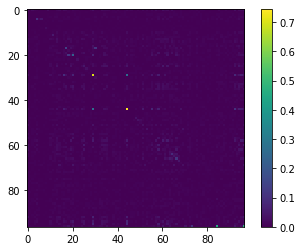

In [31]:
plt.imshow(err_mat)
plt.colorbar()

In [34]:
err_mat

array([[3.12321901e-01, 6.44615775e-01, 6.41981764e-01, ...,
        6.16494732e-01, 5.87413485e-01, 6.17638029e-01],
       [6.65581602e-01, 3.36942126e-01, 6.28363711e-01, ...,
        6.22609014e-01, 5.87928992e-01, 6.32026888e-01],
       [6.87717550e-01, 6.66539443e-01, 3.13897435e-01, ...,
        6.23331146e-01, 5.78448214e-01, 6.53099558e-01],
       ...,
       [6.57456351e-01, 6.33316367e-01, 6.02433593e-01, ...,
        1.92557936e-01, 6.73238501e-01, 6.12562284e-01],
       [6.00377979e-01, 5.78725448e-01, 5.64578581e-01, ...,
        6.78481769e-01, 2.27705213e-06, 5.94106835e-01],
       [6.59886755e-01, 6.32137152e-01, 6.23083187e-01, ...,
        6.39981487e-01, 6.12673625e-01, 3.64339862e-01]])

In [27]:
conf_mat = np.zeros((len(groups),len(groups)))
cont_mat = np.zeros((len(groups),len(groups)))

In [90]:
for test_batch_id, (X_pairs, targets, (groups1, groups2)) in enumerate(tqdm(testLoader)):
    net.eval()
    with torch.no_grad():
        X_pairs = X_pairs.to(DEVICE)
        sims = net(X_pairs)
        targets = targets[:, 0].to(DEVICE)
        cont_mat[groups1, groups2] += 1
        cont_mat[groups2, groups1] += 1
        groups1, groups2 = groups1[(sims>0.5) & (targets==0.)], groups2[(sims>0.5) & (targets==0.)]
        conf_mat[groups1, groups2] += 1
        conf_mat[groups2, groups1] += 1
#         test_acc += torch.mean(((sims>.5) == targets).float()).item()
        loss = loss_fn(sims, targets)
#         test_loss_val += loss.item()
    del X_pairs; del sims; del targets

In [91]:
conf_mat = conf_mat / (cont_mat + 1e-5)

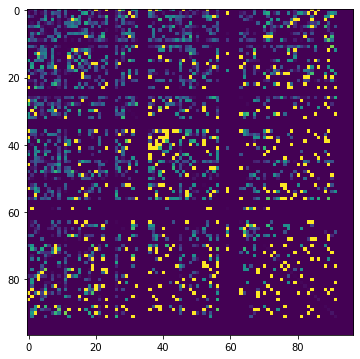

In [98]:
plt.figure(figsize=(6,6))
plt.imshow(conf_mat)

In [28]:
torch.save(net.state_dict(), 'SiameseStampNet-checkpoint-v5.pt')

In [22]:
''.join(np.random.choice([char for char in string.ascii_uppercase + string.digits]) for _ in range(10))

'W360INFTV6'

In [52]:
net.load_state_dict(torch.load('SiameseStampNet-checkpoint-v6.pt', map_location=DEVICE))
net.eval()
print('Checkpoint loaded!')

Checkpoint loaded!


In [27]:
ann_df = pkl.load(open('ann_df.pkl', 'rb+'))

In [28]:
df_unique  = df[df.groupby('path').name.transform(lambda x: len(set(x)))==1]

In [29]:
max_paths = df_unique.groupby('path').points.nunique().sort_values().index.values[::-1]

In [30]:
#95 #595 #666

In [32]:
inferenceSet = SiameseStampsDataset(card2paths, {}, {}, {}, [dummy_transforms, dummy_transforms]) 

In [33]:
# compute confusion matrix
inferenceSet = SiameseStampsDataset(card2paths, {}, {}, {}, [dummy_transforms, dummy_transforms])         
template_paths = sorted([sorted(paths) for group, paths in train_group2paths.items()])
template_vecs = np.zeros((len(template_paths), 2048))

for i, group_paths in enumerate(template_paths):
    template_patches_i = inferenceSet.get_boxes(group_paths, False)

    template_patches_GPU_i = template_patches_i.to(DEVICE)
    net.eval()
    with torch.no_grad():
        template_vecs_i = net.forward_one(template_patches_GPU_i).cpu().detach().numpy()
    del template_patches_GPU_i
    template_vecs[i] = template_vecs_i.mean(axis=0)

In [35]:
pkl.dump(template_vecs, open('template_vecs.pkl','wb+'))

In [132]:
template_paths = sorted([sorted(paths) for group, paths in train_group2paths.items()])
template_paths_show = sorted([sorted(paths)[0] for group, paths in train_group2paths.items()])

template_vecs = np.zeros((len(template_paths), 2048))
template_img_patches = []
for i, group_paths in enumerate(tqdm(template_paths)):
    template_patches_i, template_img_patches_i = inferenceSet.get_boxes(group_paths, True)

    template_patches_GPU_i = template_patches_i.to(DEVICE)
    net.eval()
    with torch.no_grad():
        template_vecs_i = net.forward_one(template_patches_GPU_i).cpu().detach().numpy()
    del template_patches_GPU_i
    template_vecs[i] = template_vecs_i.mean(axis=0)
    template_img_patches.append(template_img_patches_i[0])
    
conf_mat = np.zeros((len(groups),len(groups)))

test_paths = sorted([sorted(paths) for group, paths in test_group2paths.items()])

for i, group_paths in enumerate(tqdm(test_paths)):
    test_patches_i, test_img_patches_i = inferenceSet.get_boxes(group_paths, True)
    test_patches_GPU_i = test_patches_i.to(DEVICE)
    net.eval()
    with torch.no_grad():
        test_vecs_i = net.forward_one(test_patches_GPU_i).cpu().detach().numpy()
        scores = (np.sum(np.mean(test_vecs_i, axis=0) * template_vecs, axis=1).ravel() + 1) / 2
        scores[i] = 1 - scores[i]
        scores = scores**5
        conf_mat[i] = scores / np.sum(scores)

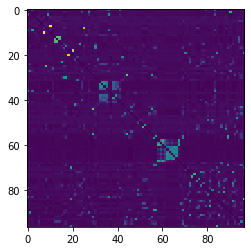

In [134]:
plt.imshow(conf_mat)

<BarContainer object of 97 artists>

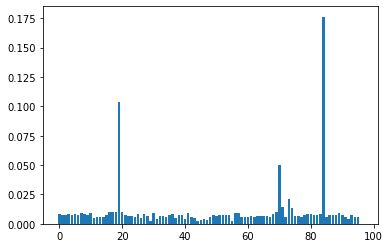

In [133]:
plt.bar(range(len(conf_mat)), conf_mat[-1])

In [36]:
from sklearn.cluster import KMeans, k_means
import shutil

In [51]:
paths = []
vecs = np.zeros((0, 2048))
for k, selected_path in enumerate(tqdm(max_paths)):
    selected_card = selected_path.split('/')[-1].split('.')[0]
    if selected_card not in card2paths:
        continue
    box_paths = [path for path in card2paths[selected_card] if path.split('/')[-1] not in list(map(lambda x: x.split('/')[-1],trainSet.boxes + testSet.boxes))]
    if len(box_paths)==0:
        continue
    patches, img_patches = inferenceSet.get_boxes(box_paths, show=True)
    patches_GPU = patches.to(DEVICE)
    net.eval()
    with torch.no_grad():
        card_vecs = net.forward_one(patches_GPU).cpu().detach().numpy()
    paths = paths + box_paths
    vecs = np.concatenate([vecs, card_vecs])

In [52]:
template_paths = sorted([sorted(paths) for group, paths in train_group2paths.items()])
template_paths_show = sorted([sorted(paths)[0] for group, paths in train_group2paths.items()])

template_vecs = np.zeros((len(template_paths), 2048))
template_img_patches = []
for i, group_paths in enumerate(tqdm(template_paths)):
    template_patches_i, template_img_patches_i = inferenceSet.get_boxes(group_paths, True)

    template_patches_GPU_i = template_patches_i.to(DEVICE)
    net.eval()
    with torch.no_grad():
        template_vecs_i = net.forward_one(template_patches_GPU_i).cpu().detach().numpy()
    del template_patches_GPU_i
    template_vecs[i] = template_vecs_i.mean(axis=0)
    template_img_patches.append(template_img_patches_i[0])

In [54]:
import shutil

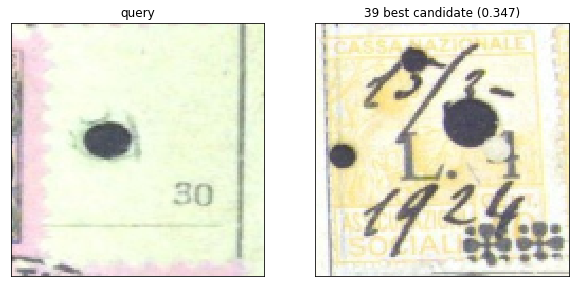

Same type? 9


In [55]:
most_simlar_vec_ids, story = [], []
score = 1
for i, template_vec in enumerate(template_vecs):
    if i<5:
        continue
    scores = np.sum(vecs * template_vec, axis=1)
    most_simlar_vec_id = np.argsort(scores)[::-1]
    most_simlar_vec_ids.append(most_simlar_vec_id)
    score = 1
    for idx in most_simlar_vec_id:
        if scores[idx] > score:
            continue
        fig, axes = plt.subplots(1, 2, figsize=(10,7))
        ax1, ax2 = axes.ravel()
        ax1.set_title('query')
        ax1.imshow(cv2.resize(plt.imread(paths[idx]), (120,120)))
        ax2.set_title('{} best candidate ({:.3f})'.format(len(group2paths['group_{}'.format(str(i).zfill(3))]), scores[idx]))
        ax2.imshow(cv2.resize(plt.imread(template_paths_show[i]), (120,120)))
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        plt.show()
        same = int(input('Same type?'))
        clear_output(wait=True)
        if same == 1:
            dst_path = os.path.join(DATA_DIR, 'group_'+str(i).zfill(3), paths[idx].split('/')[-1])
            shutil.copy(paths[idx], dst_path)
            story.append(dst_path)
        if same == 2:
            pass
        if same == 0:
            os.remove(story[-1])
            story = story[:-1]
        if same == 3:
            score = float(input('Score?'))
        elif same not in [0,1,2,3]:
            break
    clear_output(wait=True)

In [49]:
paths[idx]

'/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/55589_6b/(1411,1082,1652,1271).jpg'

In [50]:
shutil.copy(paths[idx], '(1411,1082,1652,1271).jpg')

'(1411,1082,1652,1271).jpg'

In [57]:
os.remove(os.path.join(DATA_DIR, 'group_'+str(20).zfill(3), story[-1].split('/')[-1]))

0.562 437/777
0
1
2
0.564 438/777
0
1
2
0.565 439/777
0
1
2
0.566 440/777
0
1
2
0.568 441/777
0
1
2
0.569 442/777
0
1
2
0.570 443/777
0
1
2
0.571 444/777
0
1
2


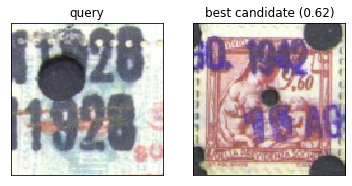

KeyboardInterrupt: 

In [34]:
story = []
for k, selected_path in enumerate(np.array(max_paths)[np.random.permutation(len(max_paths))]):
    selected_card = selected_path.split('/')[-1].split('.')[0]
    if selected_card not in card2paths:
        continue
    box_paths = [path for path in card2paths[selected_card] if path.split('/')[-1] not in list(map(lambda x: x.split('/')[-1],trainSet.boxes))]
    if len(box_paths)==0:
        continue
    patches, img_patches = inferenceSet.get_boxes(box_paths, show=True)
    patches_GPU = patches.to(DEVICE)
    net.eval()
    with torch.no_grad():
        vecs = net.forward_one(patches_GPU).cpu().detach().numpy()
        
    n_vecs = len(vecs)
    n_clusters = min(n_vecs,3)
    centroids, cluster_ids, _ = k_means(vecs, n_clusters)

    medoid_vecs = np.zeros((n_clusters, 2048))
    medoid_patches, medoid_paths = [],  []
    for i in range(n_clusters):
        medoid_id = np.argmin(np.sum((vecs - centroids[i])**2, axis=1))
        medoid_patches.append(img_patches[medoid_id])
        medoid_paths.append(box_paths[medoid_id])
        medoid_vecs[i] = vecs[medoid_id]
        vecs = np.concatenate([vecs[:medoid_id],vecs[medoid_id+1:]])
        img_patches = img_patches[:medoid_id] + img_patches[medoid_id+1:]
        box_paths = box_paths[:medoid_id] + box_paths[medoid_id+1:]
    
    mat = np.zeros((n_clusters, len(template_vecs)))
    for i in range(n_clusters):
        mat[i] = (medoid_vecs[i:i+1] * template_vecs).sum(axis=1)
    print('{:.3f} {:.0f}/{:.0f}'.format(k/len(max_paths), k, len(max_paths)))
    output_folder = 'classification_output'
    os.makedirs(output_folder, exist_ok=True)
    for i in range(n_clusters):
        medoid_path = medoid_paths[i]
        print(i, )
        best_template_ids = np.argsort(mat[i])[::-1]
        best_scores = np.sort(mat[i])[::-1]
        if len(group2paths['group_'+str(best_template_ids[0]).zfill(3)]) > 10:
            continue
        for j in range(len(best_template_ids)):
            fig, axes = plt.subplots(1, 2)
            ax1, ax2 = axes.ravel()
            ax1.set_title('query')
            ax1.imshow(medoid_patches[i])
            ax2.set_title('best candidate ({:.2f})'.format(best_scores[j]))
            ax2.imshow(cv2.resize(plt.imread(template_paths_show[best_template_ids[j]]), (120,120)))
            ax1.set_xticks([])
            ax1.set_yticks([])
            ax2.set_xticks([])
            ax2.set_yticks([])
            plt.show()
            same = int(input('Same type?'))
            clear_output(wait=True)
            if same == 1:
                os.makedirs(os.path.join(output_folder, selected_card), exist_ok=True)
                fig, axes = plt.subplots(1, 2)
                ax1, ax2 = axes.ravel()
                ax1.set_title('query')
                ax1.imshow(medoid_patches[i])
                ax2.set_title('best candidate ({:.2f})'.format(best_scores[j]), color='r')
                ax2.imshow(cv2.resize(plt.imread(template_paths_show[best_template_ids[j]]), (120,120)))
                ax1.set_xticks([])
                ax1.set_yticks([])
                ax2.set_xticks([])
                ax2.set_yticks([])
                medoid_name = medoid_paths[i].split('/')[-1].split('.')[0]
                plt.savefig(f'{output_folder}/{selected_card}/{medoid_name}.png', transparent=True)
                plt.close()
                shutil.copy(medoid_path, os.path.join(DATA_DIR, 'group_'+str(best_template_ids[j]).zfill(3), medoid_path.split('/')[-1]))
                story.append(medoid_paths[i])
                break
            if same == 2:
                pass
            if same not in [0,1,2]:
                break
            if same == 0:
                pos_box2id[story[-1]] = -1
                neg_box2id[story[-1]] = neg_box2id[story[-1]][:-1]
                clear_output(wait=True)
                break
        clear_output(wait=True)

In [ ]:
# story

In [75]:
trainSet.n_boxes + testSet.n_boxes

2413

In [42]:
sp = '(343,1449,560,1702).jpg'
for folder in os.listdir(DATA_DIR):
    for fn in os.listdir(os.path.join(DATA_DIR, folder)):
        if fn == sp:
            print(folder)

group_071


In [45]:
shutil.copy(medoid_path, os.path.join(DATA_DIR, 'group_'+str(97).zfill(3), medoid_path.split('/')[-1]))

'stamp_groups/group_097/(2117,1213,2310,1424).jpg'

In [67]:
template_paths = sorted([sorted(paths) for group, paths in group2paths.items()])
template_paths_show = sorted([sorted(paths)[0] for group, paths in group2paths.items()])

template_vecs = np.zeros((len(template_paths), 2048))
template_img_patches = []
group_vecs, vecs = [], np.zeros((0, 2048))
for i, group_paths in enumerate(template_paths):
    template_patches_i, template_img_patches_i = inferenceSet.get_boxes(group_paths, True)

    template_patches_GPU_i = template_patches_i.to(DEVICE)
    net.eval()
    with torch.no_grad():
        template_vecs_i = net.forward_one(template_patches_GPU_i).cpu().detach().numpy()
    del template_patches_GPU_i
    group_vecs.append(template_vecs_i)
    vecs = np.concatenate([vecs, template_vecs_i])
    template_img_patches.append(template_img_patches_i[0])

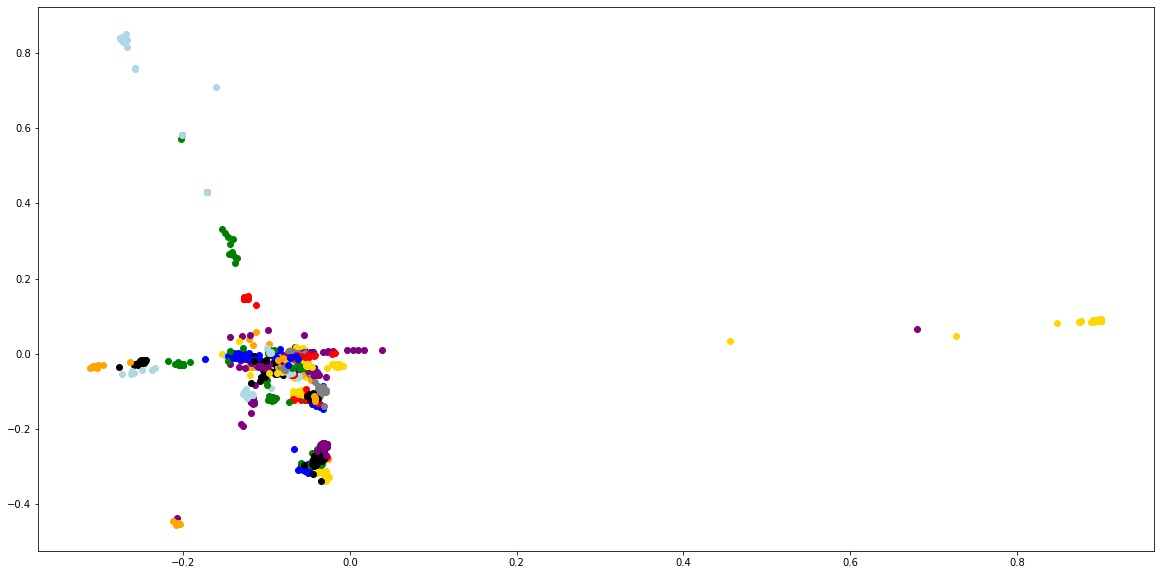

In [73]:
from sklearn.decomposition import PCA
# pca = PCA().fit(vecs)
colors = ['r','b','g','black','purple','gold','orange', 'gray','lightblue']
plt.figure(figsize=(20,10))
for i, group in enumerate(groups):
    vecs_pca = pca.transform(group_vecs[i])
    plt.scatter(vecs_pca[:,0], vecs_pca[:,1], color = colors[i%len(colors)])
plt.show()

In [44]:
os.makedirs('stamp_groups/group_097')

In [53]:
os.path.join(DATA_DIR, 'group_'+str().zfill(3), medoid_path.split('/')[-1])

'stamp_groups/group_000/(518,314,710,496).jpg'

In [47]:
template_paths_show

['stamp_groups/group_000/000_template.jpg',
 'stamp_groups/group_001/001_template.jpg',
 'stamp_groups/group_002/002_template.jpg',
 'stamp_groups/group_003/003_template.jpg',
 'stamp_groups/group_004/(1023,1460,1256,1728).jpg',
 'stamp_groups/group_005/005_template.jpg',
 'stamp_groups/group_006/006_template.jpg',
 'stamp_groups/group_007/(1366,1609,1560,1808).jpg',
 'stamp_groups/group_008/(694,320,892,507).jpg',
 'stamp_groups/group_009/(1127,1076,1324,1266).jpg',
 'stamp_groups/group_010/010_template.jpg',
 'stamp_groups/group_011/(2271,464,2485,659).jpg',
 'stamp_groups/group_012/(1374,664,1619,926).jpg',
 'stamp_groups/group_013/(1411,158,1642,413).jpg',
 'stamp_groups/group_014/(1380,702,1616,965).jpg',
 'stamp_groups/group_015/(1108,704,1304,899).jpg',
 'stamp_groups/group_016/016_template.jpg',
 'stamp_groups/group_017/(476,1587,662,1778).jpg',
 'stamp_groups/group_018/(1073,672,1309,947).jpg',
 'stamp_groups/group_019/(1093,428,1318,684).jpg',
 'stamp_groups/group_020/(226,16

In [86]:
pos_box2id[medoid_paths[i]] = len(template_paths)

In [2]:
pos_box2id

NameError: name 'pos_box2id' is not defined

In [204]:
len(template_paths)

76

In [87]:
medoid_paths[i]

'/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/23297_4b/(1357,1232,1550,1428).jpg'

In [88]:
import shutil
shutil.copy('/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/23297_4b/(1357,1232,1550,1428).jpg', './catalogue/z004.jpg')

'./catalogue/z004.jpg'

In [97]:
len([v for k,v in catalogue_sets.items() if len(v)>0]), len([v for k,v in catalogue_sets.items() if len(v)>1])

(41, 31)

In [98]:
{k:v for k,v in pos_box2id.items() if v!=-1}

{'/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/100849_7b/(2331,1048,2519,1234).jpg': 45,
 '/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/100849_7b/(906,1430,1104,1621).jpg': 9,
 '/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/100849_8b/(1099,861,1291,1052).jpg': 45,
 '/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/100849_8b/(167,147,351,321).jpg': 45,
 '/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/103445_10b/(365,856,541,1049).jpg': 45,
 '/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/103445_12b/(351,895,540,1070).jpg': 56,
 '/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/103445_12b/(531,541,723,733).jpg': 45,
 '/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/103445_12b/(726,708,918,900).jpg': 45,
 '/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/103445_8b/(1568,1068,1771,1263).jpg': 45,
 '/home/ubuntu/storage/Doc2Answer/st

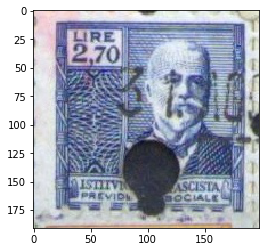

In [99]:
plt.imshow(plt.imread('/home/ubuntu/storage/Doc2Answer/stamp_detection/retrieved_stamps/100849_7b/(906,1430,1104,1621).jpg'))

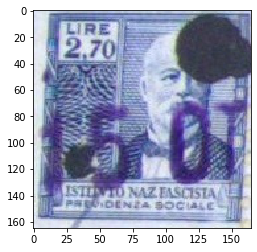

In [100]:
plt.imshow(plt.imread(template_paths[9]))

In [78]:
{k:v for k,v in neg_box2id.items() if len(v)!=0}

{}

In [ ]:
card2paths['1424_7']

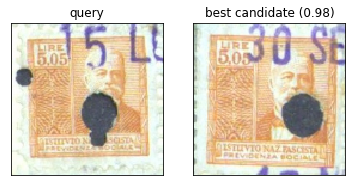

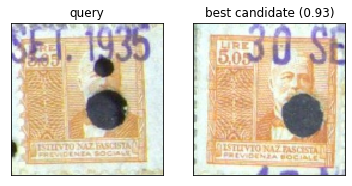

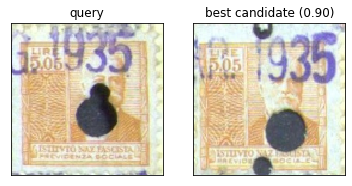

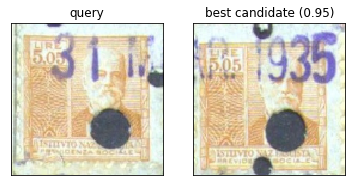

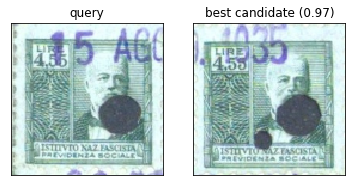

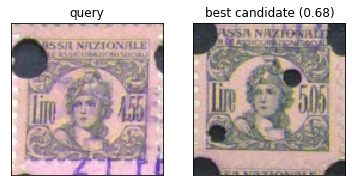

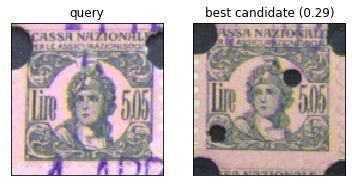

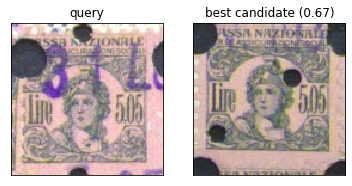

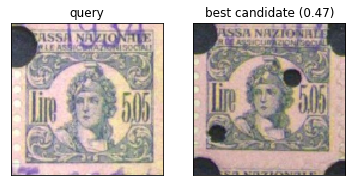

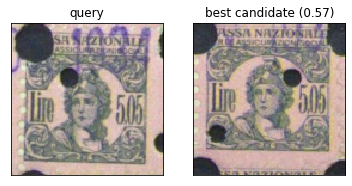

In [48]:
# selected_path = max_paths[17]
# selected_card = selected_path.split('/')[-1].split('.')[0]
# path_df = ann_df.query('path==@selected_path')
# img = cv2.cvtColor(cv2.imread(selected_path), cv2.COLOR_BGR2RGB)
# boxes = path_df['points'].values
# template_patches, template_img_patches = inferenceSet.preprocesses(img, boxes, True)

# template_patches_GPU = template_patches.to(DEVICE)
# net.eval()
# with torch.no_grad():
#     template_vecs = net.forward_one(template_patches_GPU).cpu().detach().numpy()
    
# patches, img_patches = inferenceSet.get_same_cards(selected_card, show=True)
# patches_GPU = patches.to(DEVICE)
# net.eval()
# with torch.no_grad():
#     vecs = net.forward_one(patches_GPU).cpu().detach().numpy()
    
# mat = np.zeros((len(vecs), len(template_vecs)))
# for i in range(len(vecs)):
#     mat[i] = (vecs[i:i+1] * template_vecs).sum(axis=1)
    
# output_folder = 'classification_output'
# os.makedirs(output_folder, exist_ok=True)
# for i in range(min(100, len(mat))):
#     fig, axes = plt.subplots(1, 2)
#     ax1, ax2 = axes.ravel()
#     ax1.set_title('query')
#     ax1.imshow(img_patches[i])
#     ax2.set_title('best candidate ({:.2f})'.format(max(mat[i])))
#     ax2.imshow(template_img_patches[np.argmax(mat[i])])
#     ax1.set_xticks([])
#     ax1.set_yticks([])
#     ax2.set_xticks([])
#     ax2.set_yticks([])
#     os.makedirs(os.path.join(output_folder, selected_card), exist_ok=True)
#     plt.savefig(f'{output_folder}/{selected_card}/{i}.png', transparent=True)
#     if i % 11 == 0:
#         plt.show()
#     else:
#         plt.close()

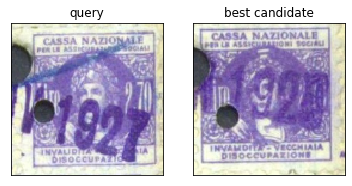

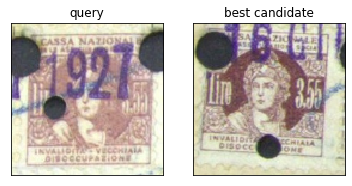

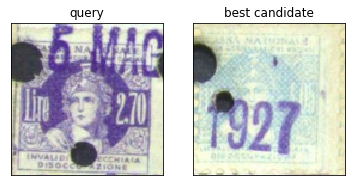

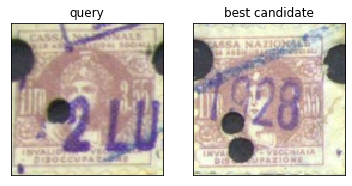

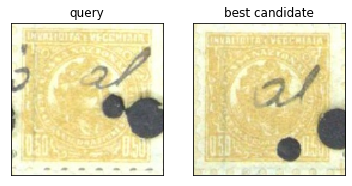

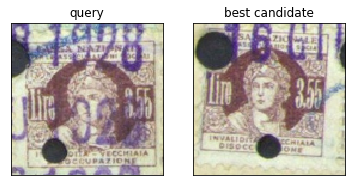

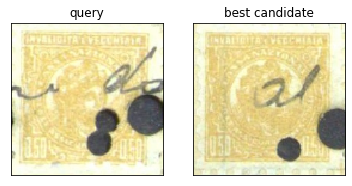

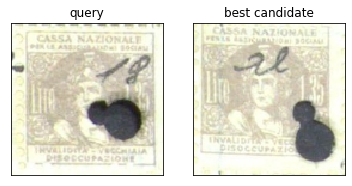

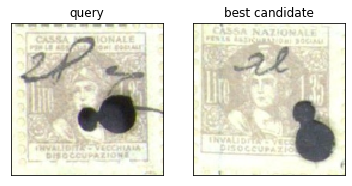

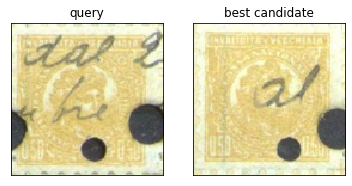

In [107]:
output_folder = 'classification_output'
os.makedirs(output_folder, exist_ok=True)
name  = selected_path.split('/')[-1].split('.')[0]
for i in range(100):
    fig, axes = plt.subplots(1, 2)
    ax1, ax2 = axes.ravel()
    ax1.set_title('query')
    ax1.imshow(img_patches[i])
    ax2.set_title('best candidate')
    ax2.imshow(template_img_patches[np.argmax(mat[i])])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    os.makedirs(os.path.join(output_folder, name), exist_ok=True)
    plt.savefig(f'{output_folder}/{name}/{i}.png', transparent=True)
    if i % 10 == 0:
        plt.show()
    else:
        plt.close()

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

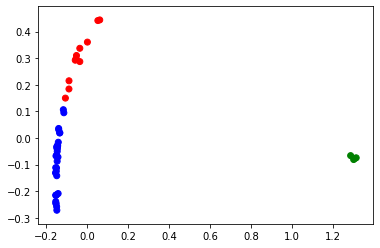

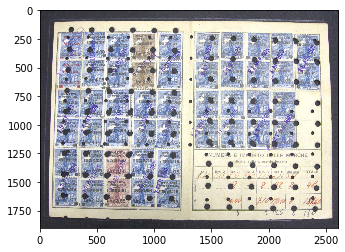

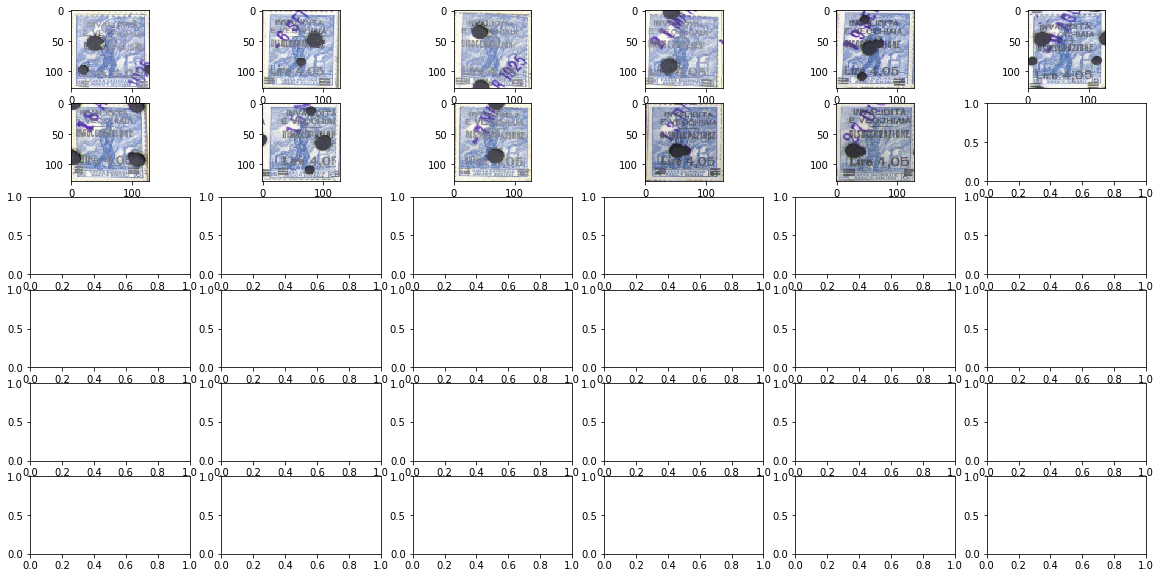

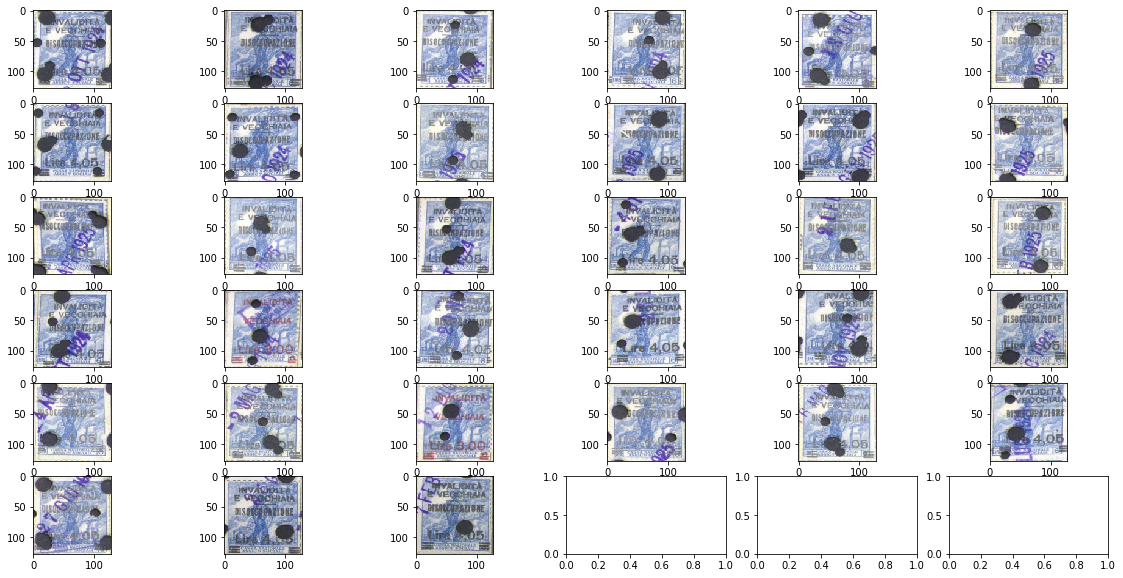

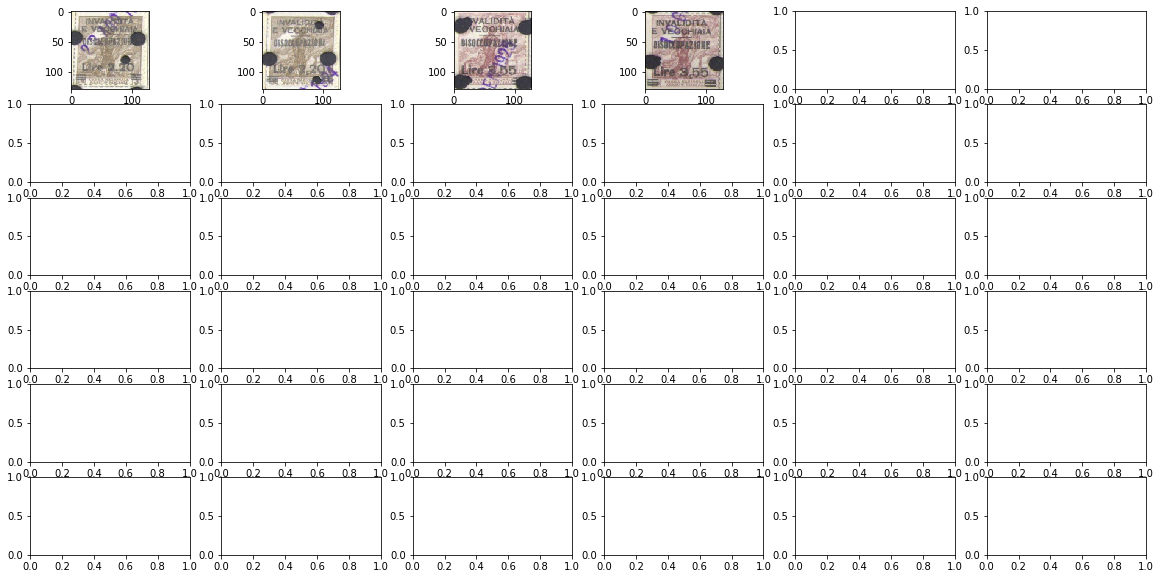

In [40]:
max_path = max_paths[519]
colors = ['r','b','g','purple','orange','brown']
patches, img_patches = inferenceSet.get_same_stamps(max_path, show=True)
patches_GPU = patches.to(DEVICE)
with torch.no_grad():
    vecs = net.forward_one(patches_GPU).cpu().detach().numpy()
n_clusters = ann_df.query('path==@max_path').shape[0]

PCA_vecs = PCA(2).fit_transform(vecs)

mat = np.zeros((len(vecs), len(vecs)))
for i in range(len(vecs)):
    mat[i] = (vecs[i:i+1] * vecs).sum(axis=1)
    
cluster_ids = KMeans(n_clusters).fit_predict(vecs)
plt.scatter(PCA_vecs[:,0], PCA_vecs[:,1], color=[colors[idx] for idx in cluster_ids])
plt.show()

img = cv2.cvtColor(cv2.imread(max_path), cv2.COLOR_BGR2RGB)
plt.imshow(img)

for cluster in range(n_clusters):
    fig, axes = plt.subplots(6, 6, figsize=(20,10))
    axes = axes.ravel()
    ids = np.argwhere(cluster_ids==cluster).ravel()
    for idx, ax in zip(ids,axes):
        ax.imshow(img_patches[idx])
    plt.show()

name                                               path  \
1607  66463_10b  /home/ubuntu/storage/Doc2Answer/download_from_...   
1608  66463_10b  /home/ubuntu/storage/Doc2Answer/download_from_...   
1609  66463_10b  /home/ubuntu/storage/Doc2Answer/download_from_...   
1610  66463_10b  /home/ubuntu/storage/Doc2Answer/download_from_...   

                                                 points  box_id  
1607  ([922, 490], [1116, 491], [1112, 670], [919, 6...       1  
1608  ([1572, 677], [1763, 682], [1762, 875], [1572,...       2  
1609  ([1766, 1063], [1575, 1049], [1571, 1247], [17...       3  
1610  ([2147, 1049], [2151, 1237], [1970, 1242], [19...       4

In [148]:
cluster_ids = KMeans(4).fit_predict(vecs)

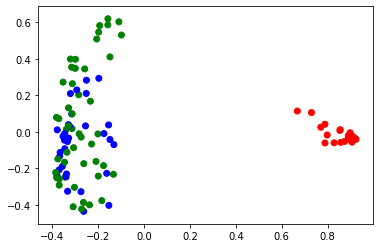

In [149]:
plt.scatter(PCA_vecs[:,0], PCA_vecs[:,1], color=['r' if idx==0 else 'b' if idx==1 else 'g' for idx in cluster_ids])

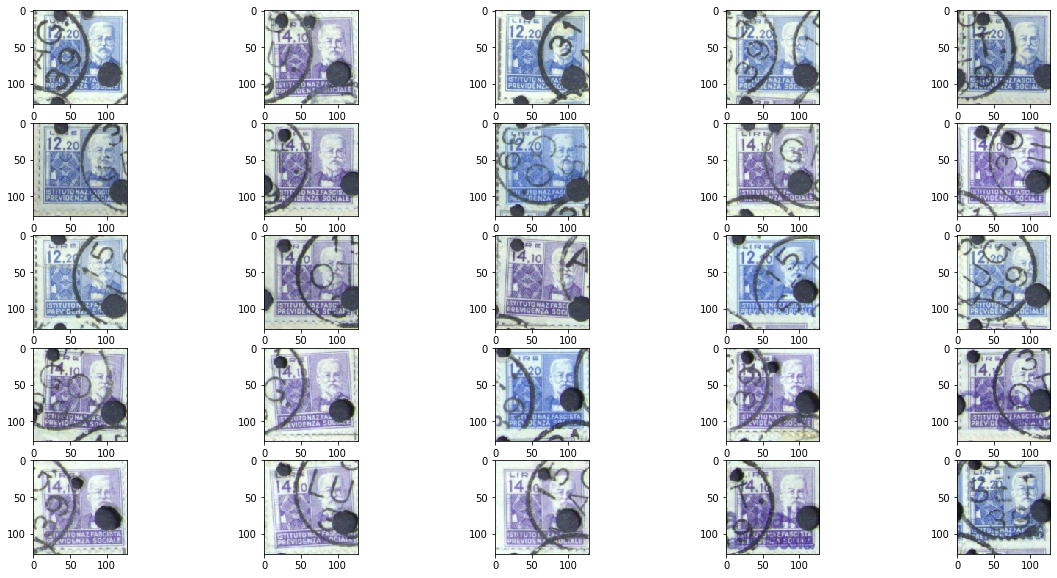

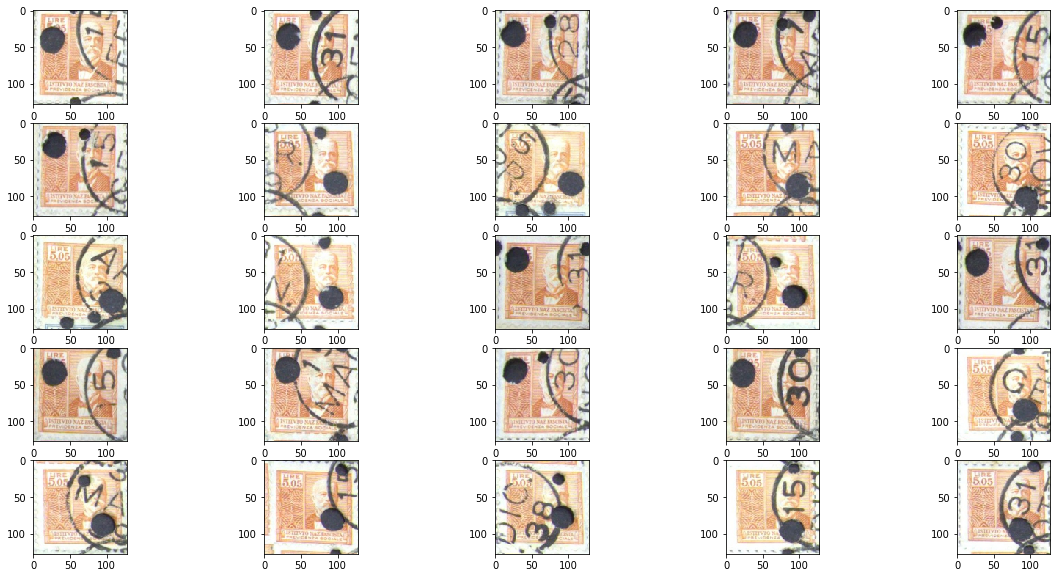

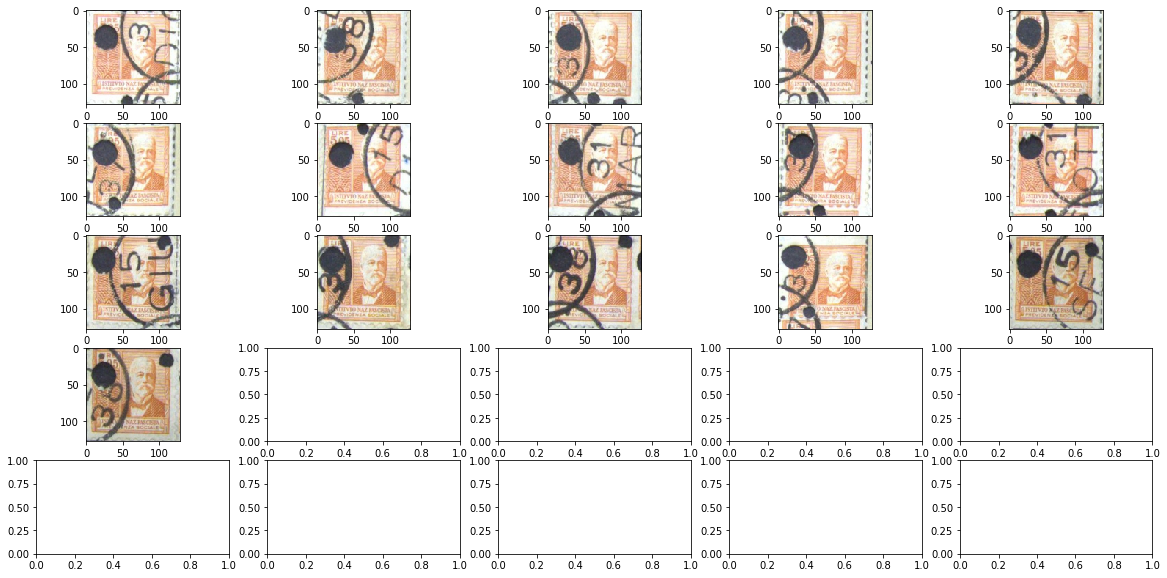

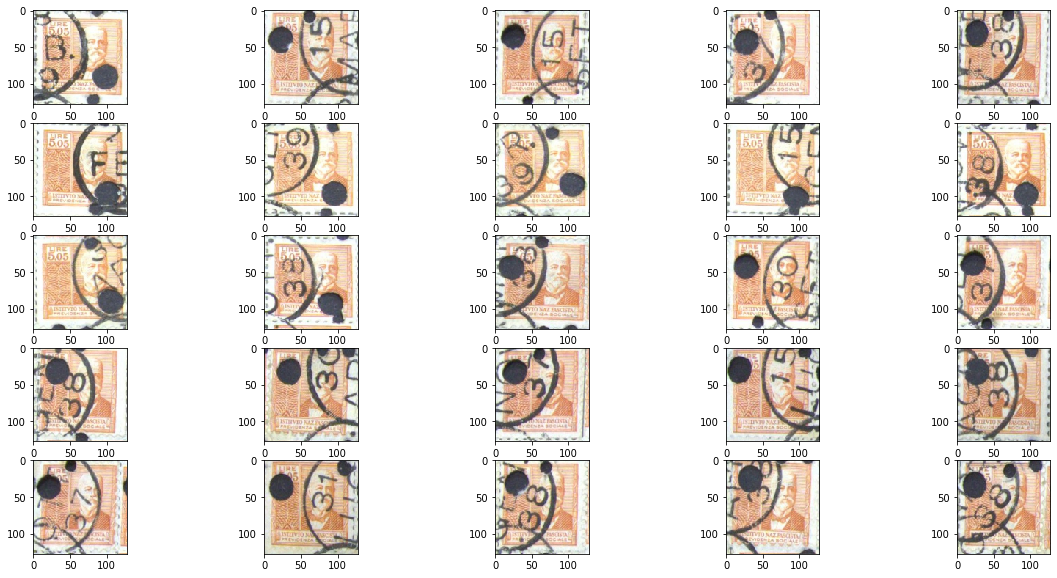

In [154]:
img = cv2.cvtColor(cv2.imread(max_path), cv2.COLOR_BGR2RGB)


for cluster in range(4):
    fig, axes = plt.subplots(5, 5, figsize=(20,10))
    axes = axes.ravel()
    ids = np.argwhere(cluster_ids==cluster).ravel()
    for idx, ax in zip(ids,axes):
        ax.imshow(img_patches[idx])
    plt.show()